In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

### This notebook produces Figure 2 in the BlueRecording Paper

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import bluepysnap as bp
from matplotlib.collections import LineCollection
from morphio import Morphology
import json
import matplotlib
import h5py
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 12})

In [4]:
#  Loads extracellular recording from simulation with distant electrodes
s1 = bp.Simulation('distant-electrodes/simulation/simulation_config.json') 
r1 = s1.reports['extracellular_report']['S1nonbarrel_neurons']

start_time = 2125 
end_time = 2175
data1 = r1.get(t_start=start_time,t_stop=end_time)

#  Loads extracellular recording from simulation with nearby electrodes
s2 = bp.Simulation('close-electrodes/simulation/simulation_config.json')
r2 = s2.reports['extracellular_report']['S1nonbarrel_neurons']

data2 = r2.get(t_start=start_time,t_stop=end_time)

In [5]:
# Loads neural compartment positions

cell_positions = pd.read_pickle('data/getPositions/positions/0/positions0.pkl')


In [6]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints of compartments for a single neuron
    '''

    
    secIds = np.array(list(position.columns))[:,1]
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos


In [7]:
midpts = getNeuronSegmentMidpts(cell_positions)

In [8]:
# Loads compartment weights for the distant electrode

fDistant = h5py.File('distant-electrodes/electrodeFile/coeffs.h5')

scalingFactorsDistant = fDistant['electrodes']['S1nonbarrel_neurons']['scaling_factors']

# Loads compartment weights for the nearby electrode

fClose = h5py.File('close-electrodes/electrodeFile/coeffs.h5')

scalingFactorsClose = fClose['electrodes']['S1nonbarrel_neurons']['scaling_factors']

# Calculates differences in compartment weights bewteen reciprocity approach and dipole approach for the distant electrode
scalingDistantReciprocity = scalingFactorsDistant[:,0]
scalingDistantDipole = scalingFactorsDistant[:,1]
offsetDistant = scalingDistantReciprocity[0]-scalingDistantDipole[0]
# Normalizes difference by range of weights
differenceDistant = (scalingDistantReciprocity-scalingDistantDipole-offsetDistant)
differenceDistant /= (np.max(scalingDistantReciprocity)-np.min(scalingDistantReciprocity))

# Calculates differences in compartment weights bewteen reciprocity approach and dipole approach for the distant electrode
scalingCloseReciprocity = scalingFactorsClose[:,0]
scalingCloseDipole = scalingFactorsClose[:,1]
offsetClose = scalingCloseReciprocity[0]-scalingCloseDipole[0]
# Normalizes difference by range of weights
differenceClose = (scalingCloseReciprocity-scalingCloseDipole-offsetClose)
differenceClose /= (np.max(scalingCloseReciprocity)-np.min(scalingCloseReciprocity))


In [9]:
# Locations of electrodes
farElectrode =  np.array([30000,-5000,-20000])
closeElectrode = np.array([4500,-1200,-3400])

The following cell produces Figure 2:

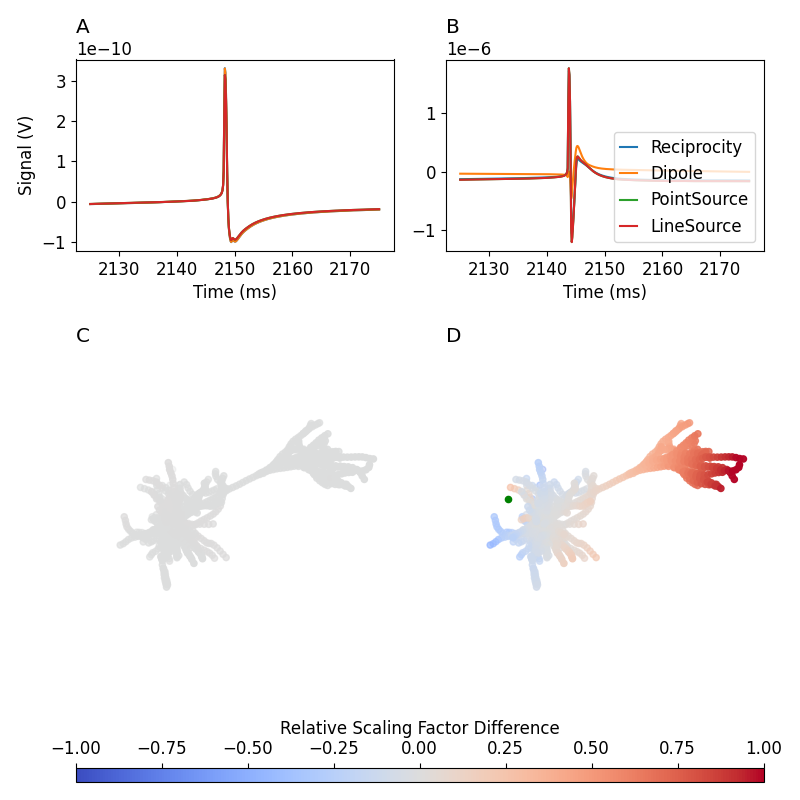

In [10]:
fig = plt.figure(figsize=(8,8))

from matplotlib.gridspec import GridSpec
gs = GridSpec(9, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[0:3, 1])
ax3 = fig.add_subplot(gs[3:-1, 0],projection='3d')
ax4 = fig.add_subplot(gs[3:-1, 1],projection='3d')
ax5 = fig.add_subplot(gs[-1, :])


#####
# Plots signals recorded from the distant electrode, with each method
ax1.plot(data1.iloc[:,0])
ax1.plot(data1.iloc[:,1])
ax1.plot(data1.iloc[:,2]-data1.iloc[:,3])
ax1.plot(data1.iloc[:,4]-data1.iloc[:,5])


ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Signal (V)')

ax1.set_title(f"A", ha='left', x=-0)

#####
# Plots signals recorded from the nearby electrode, with each method

ax2.plot(data2.iloc[:,0])
ax2.plot(data2.iloc[:,1])
ax2.plot(data2.iloc[:,2]-data2.iloc[:,3])
ax2.plot(data2.iloc[:,4]-data2.iloc[:,5])

ax2.set_xlabel('Time (ms)')

ax2.legend(['Reciprocity','Dipole','PointSource','LineSource'],handlelength=1,loc='lower right')

ax2.set_title(f"B", ha='left', x=-0)

######
# Plots differences in compartment weights between reciprocity and dipole reciprocity approaches, for the distant electrode

plot = ax3.scatter(midpts.values[0,:],midpts.values[1,:],midpts.values[2,:],c=differenceDistant,vmin=-1,vmax=1,cmap='coolwarm')
ax3.scatter(farElectrode[0],farElectrode[1],farElectrode[2],c='g')

ax3.axis('off')

ax3.set_title(f"C", ha='left', x=-0)
ax3.view_init(elev=30., azim=-125)
ax3.set_xlim((4291, 5490))
ax3.set_ylim((-1938, -1165))
ax3.set_zlim((-3690, -2972))

plt.tight_layout()

######
# Plots differences in compartment weights between reciprocity and dipole reciprocity approaches, for the nearby electrode

plot = ax4.scatter(midpts.values[0,:],midpts.values[1,:],midpts.values[2,:],c=differenceClose,vmin=-1,vmax=1,cmap='coolwarm')
ax4.scatter(closeElectrode[0],closeElectrode[1],closeElectrode[2],c='g')

ax4.axis('off')


ax4.set_title(f"D", ha='left', x=-0)
ax4.view_init(elev=30., azim=-125)

ax4.set_xlim((4291, 5490))
ax4.set_ylim((-1938, -1165))
ax4.set_zlim((-3690, -2972))

fig.colorbar(plot,cax=ax5,label='Relative Scaling Factor Difference',location='top')

plt.tight_layout()

plt.savefig('figures/verification.png',dpi=300)
